Dataset Desription:

**Transaction Data**

Transaction_ID: Unique identifier for each transaction.

Customer_ID: Unique identifier for the customer associated with the transaction.

Product_ID: Unique identifier for the product purchased in the transaction.

Transaction_Date: The date when the transaction occurred.

**Product Information**

Category: The category to which the product belongs (e.g., Electronics, Clothing).

Units_Sold: The quantity of the product sold in the transaction.

Discount_Applied: The discount percentage applied to the product during the transaction.

Revenue: Total revenue generated from the transaction, calculated as Price x Units Sold x (1 - Discount).

**Customer Demographics**

Customer_ID: Unique identifier for each customer (repeated for easier reference).

Age: Age of the customer.

Gender: Gender of the customer (Male, Female, Other).

Location: Geographical location of the customer.

Customer_Lifetime_Value: Estimated lifetime value of the customer to the e-commerce platform.

**Advertising Metrics**

Clicks: Number of ad clicks associated with the product during the time of the transaction.

Impressions: Number of ad impressions served during the campaign.

Conversion_Rate: Calculated as Clicks / Impressions, representing the percentage of impressions that resulted in clicks.

Ad_CTR: Click-through rate (CTR) for the advertisement, representing the effectiveness of the ad campaign.

Ad_CPC: Cost-per-click for the advertisement.

Ad_Spend: Total advertising spend for the product, calculated as Ad_CTR x Ad_CPC x 1000.

**Seasonal and Regional Information**

Region: The geographical region where the transaction occurred (e.g., North America, Europe, Asia).

Seasonality Effects: Implied through patterns in transaction dates and revenue, reflecting holiday promotions and season-based purchasing trends.

In [303]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import joblib
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [304]:
# Load the dataset
df=pd.read_csv('../Data/synthetic_ecommerce_data.csv')

In [305]:
# Checking the first five rows to ensure the data is loaded correctly
df.head()

,Transaction_ID,Customer_ID,Product_ID,Transaction_Date,Units_Sold,Discount_Applied,Revenue,Clicks,Impressions,Conversion_Rate,Category,Region,Ad_CTR,Ad_CPC,Ad_Spend
0,8b460852-7c64-46fa-998b-b0976879d082,Customer_65,Product_224,2024-10-06,134,0.14,305.54,11,65,0.17,Electronics,Europe,0.0180,0.55,9.90
1,418612e7-8744-4ba3-bb0c-105b47e2a968,Customer_1910,Product_584,2024-10-29,109,0.30,1102.19,15,201,0.07,Home Appliances,Asia,0.1589,0.40,63.56
2,5bc3b98f-cb0c-4b12-947c-df8bbb35a73e,Customer_2306,Product_374,2024-04-04,116,0.04,471.29,16,199,0.08,Toys,Asia,0.0596,1.50,89.40
3,28fb67c8-e8c0-447a-841c-f760730de0eb,Customer_17206,Product_220,2024-08-25,125,0.20,980.26,12,355,0.03,Clothing,Europe,0.0444,0.44,19.54
4,8bee087a-a8a9-45bb-89d7-04d1710f1b00,Customer_16033,Product_358,2024-05-05,132,0.07,803.76,44,355,0.12,Books,North America,0.1270,0.53,67.31


In [306]:
# Check how manys rows and cols
df.shape

(100000, 15)

In [307]:
# Check the nulls, and the data types of the cols
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Transaction_ID    100000 non-null  object 
 1   Customer_ID       100000 non-null  object 
 2   Product_ID        100000 non-null  object 
 3   Transaction_Date  100000 non-null  object 
 4   Units_Sold        100000 non-null  int64  
 5   Discount_Applied  100000 non-null  float64
 6   Revenue           100000 non-null  float64
 7   Clicks            100000 non-null  int64  
 8   Impressions       100000 non-null  int64  
 9   Conversion_Rate   100000 non-null  float64
 10  Category          100000 non-null  object 
 11  Region            100000 non-null  object 
 12  Ad_CTR            100000 non-null  float64
 13  Ad_CPC            100000 non-null  float64
 14  Ad_Spend          100000 non-null  float64
dtypes: float64(6), int64(3), object(6)
memory usage: 11.4+ MB


No nulls and these cols (Transaction_ID,
Customer_ID, Product_ID) are trivial need to be deleted

In [308]:
df.drop(['Transaction_ID', 'Customer_ID', 'Product_ID'], axis=1, inplace=True)

In [309]:
# Check the duplicates
df.duplicated().sum()

0

In [310]:
# Check some statistical info about the dataset to have an overview if there are some outliers and the dataset distribution
# Include all cols even the categorical (nominal) ones
df.describe(include='all')

,Transaction_Date,Units_Sold,Discount_Applied,Revenue,Clicks,Impressions,Conversion_Rate,Category,Region,Ad_CTR,Ad_CPC,Ad_Spend
count,100000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000,100000,100000.000000,100000.000000,100000.000000
unique,366,NaN,NaN,NaN,NaN,NaN,NaN,5,3,NaN,NaN,NaN
top,2024-10-14,NaN,NaN,NaN,NaN,NaN,NaN,Electronics,Asia,NaN,NaN,NaN
freq,319,NaN,NaN,NaN,NaN,NaN,NaN,21533,33472,NaN,NaN,NaN
mean,NaN,128.328580,0.149871,553.110811,24.539170,254.539060,0.198138,NaN,NaN,0.104988,1.051250,110.477240
std,NaN,49.679873,0.086692,428.366294,14.412477,141.466606,0.361187,NaN,NaN,0.054806,0.549252,87.015846
min,NaN,51.000000,0.000000,7.650000,0.000000,10.000000,0.000000,NaN,NaN,0.010000,0.100000,1.050000
25%,NaN,84.000000,0.070000,221.260000,12.000000,132.000000,0.050000,NaN,NaN,0.057500,0.580000,38.610000
50%,NaN,127.000000,0.150000,428.155000,25.000000,254.000000,0.100000,NaN,NaN,0.105200,1.050000,87.240000
75%,NaN,166.000000,0.220000,805.865000,37.000000,377.000000,0.190000,NaN,NaN,0.152300,1.530000,164.220000


In [311]:
df['Transaction_Date'] = pd.to_datetime(df['Transaction_Date'])

Univariate Analysis

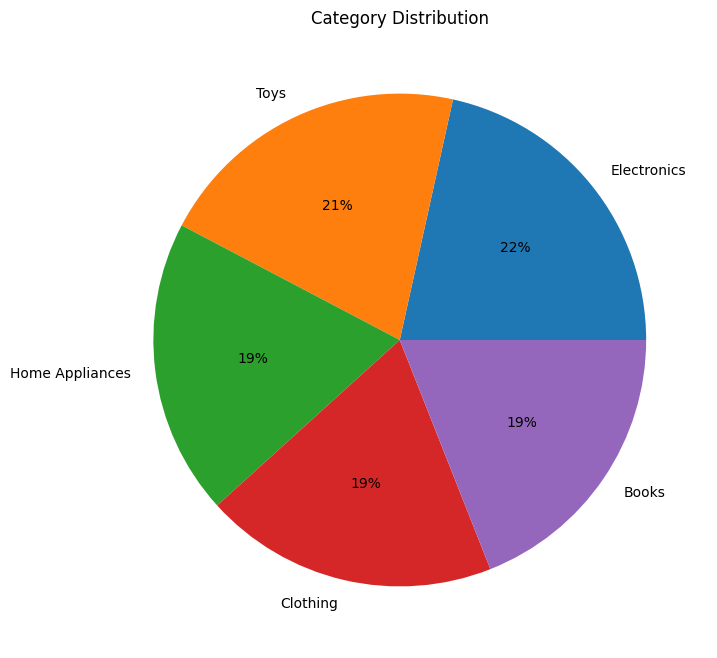

In [312]:
# Create a pie chart of the Category column
plt.figure(figsize=(8, 8))

counts = df["Category"].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.0f%%')
plt.title('Category Distribution')

plt.show()

Almost balanced Category distribution among these five options

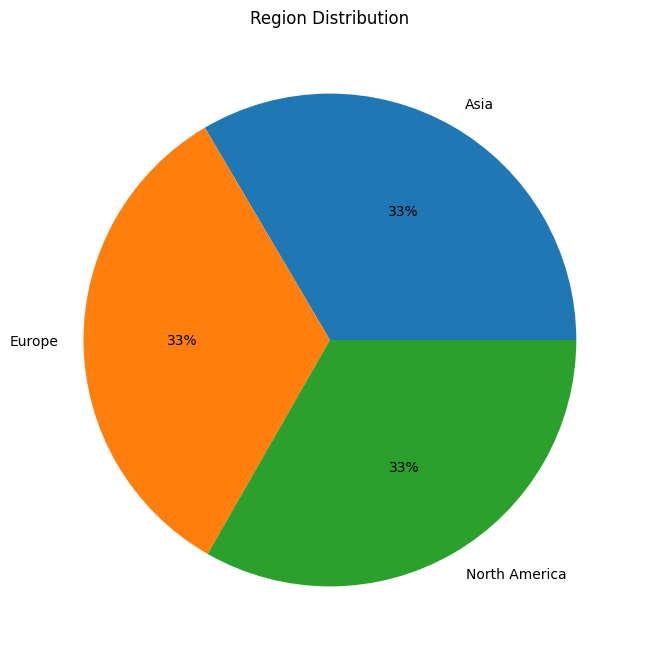

In [313]:
# Create a pie chart of the Region column
plt.figure(figsize=(8, 8))

counts = df["Region"].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.0f%%')
plt.title('Region Distribution')

plt.show()

The distribution among the regions is perfectly balanced

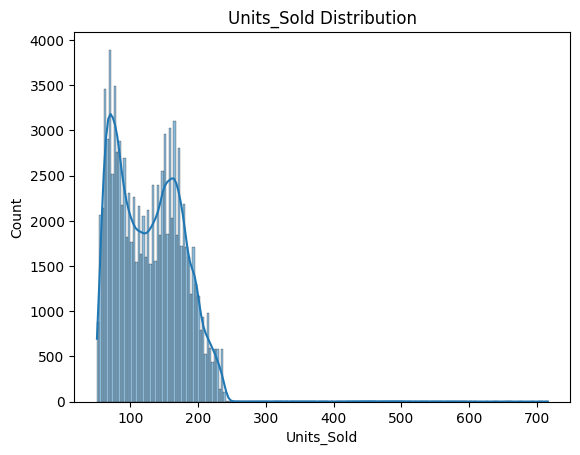

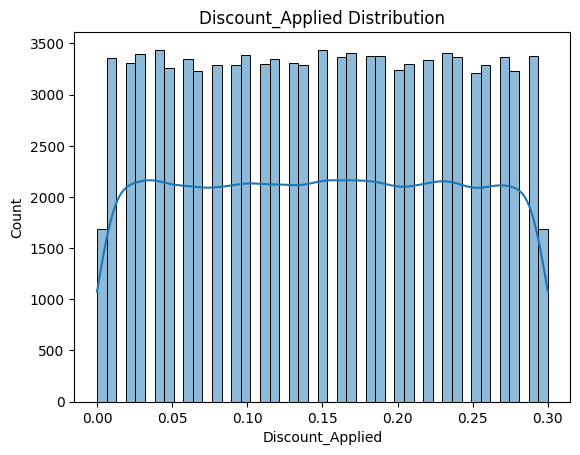

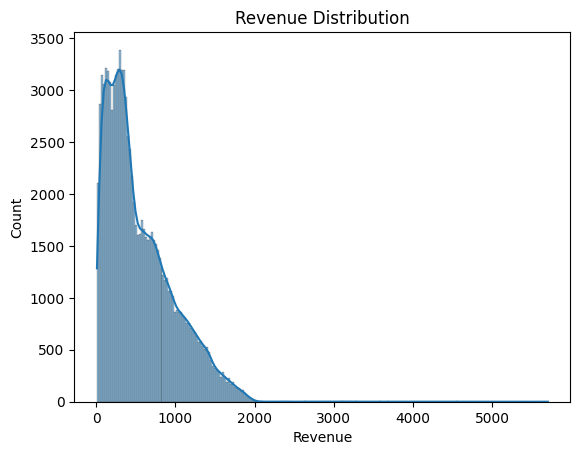

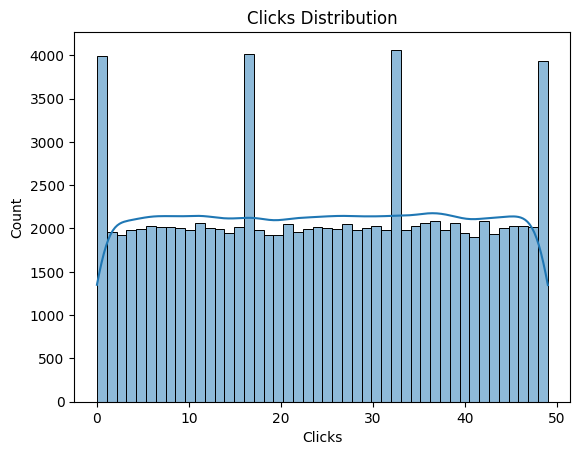

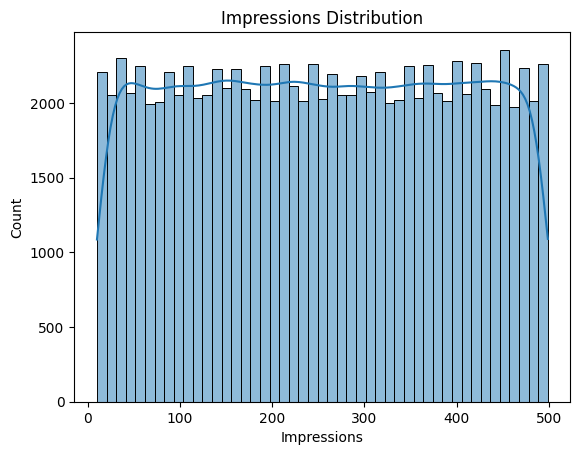

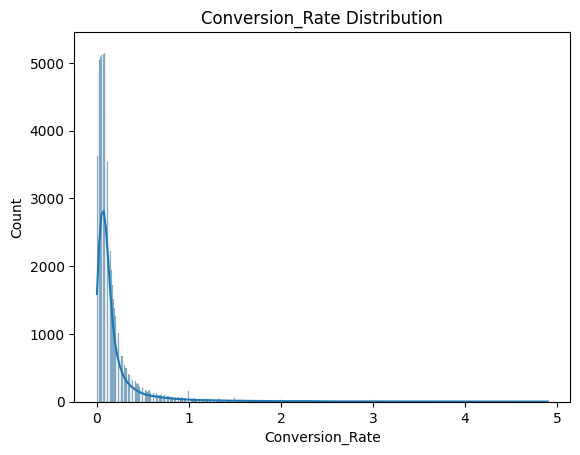

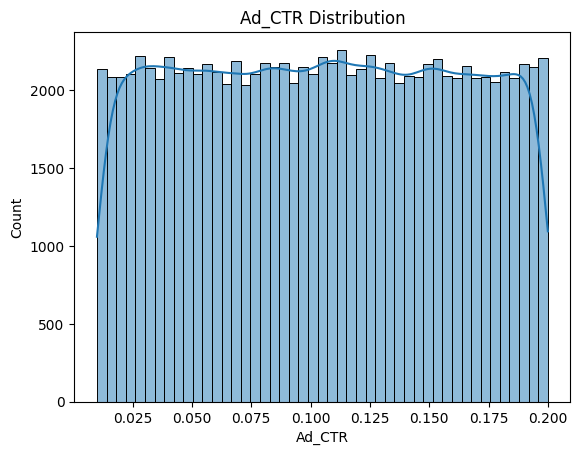

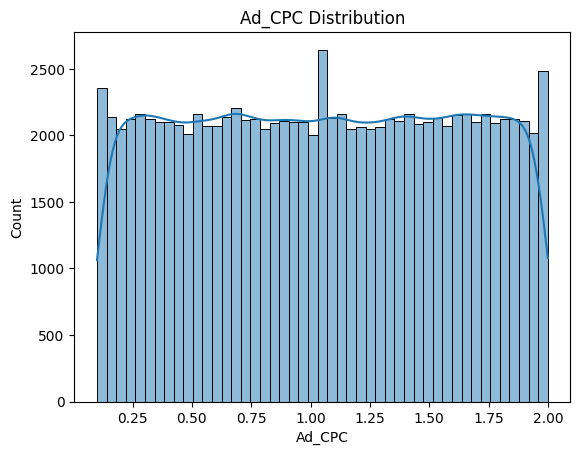

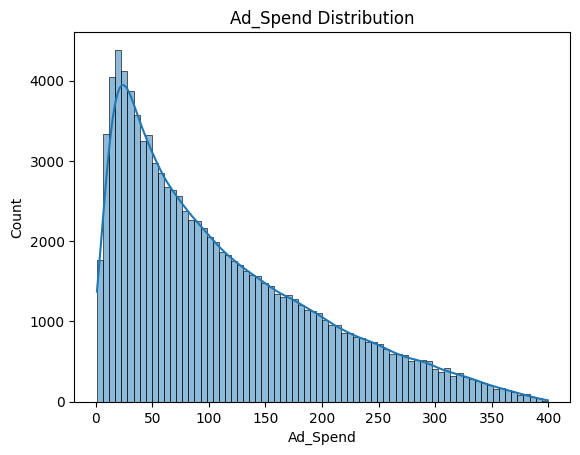

In [314]:
# Numerical Cols Distribution
cols=np.array(df.select_dtypes(include=['int64', 'float64']).columns)
for col in cols:
    sns.histplot(df[col], kde=True)
    plt.title(f'{col} Distribution')
    plt.show()

Some of the columns (Ad_Spend, Revenue, Conversion_Rate) are exponentially distributed --> log scaling

Others (Ad_CPC, Ad_CTR, Clicks, Impressions, Discount_Applied) are uniformly distributed --> min-max scaling

Bivariate Analysis

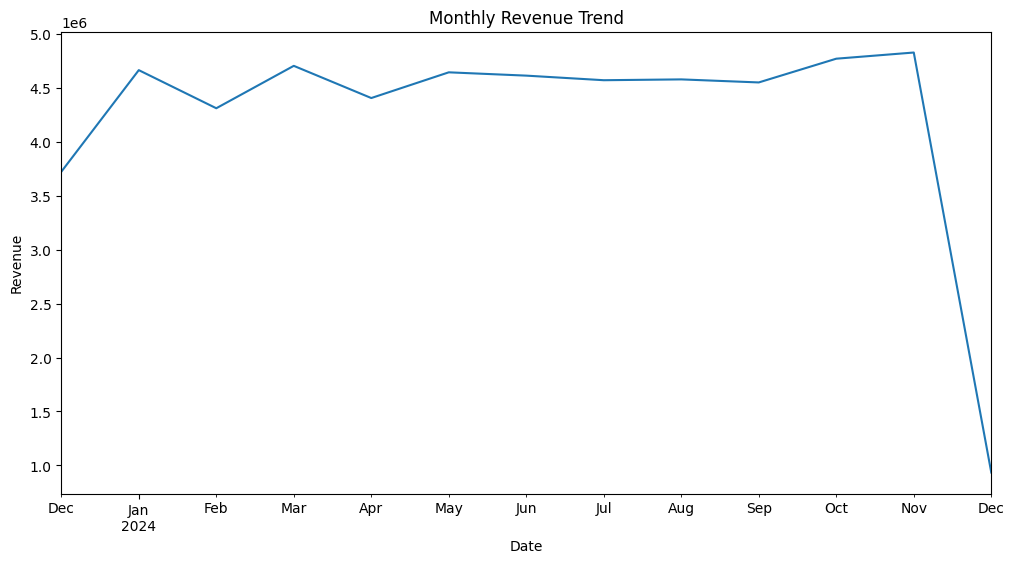

In [315]:
# Revenue over time (aggregated Monthly)
monthly_revenue = df.groupby(pd.Grouper(key='Transaction_Date', freq='M'))['Revenue'].sum()
monthly_revenue.plot(title='Monthly Revenue Trend', figsize=(12,6))
plt.ylabel('Revenue')
plt.xlabel('Date')
plt.show()

November is the month with the highest revenue

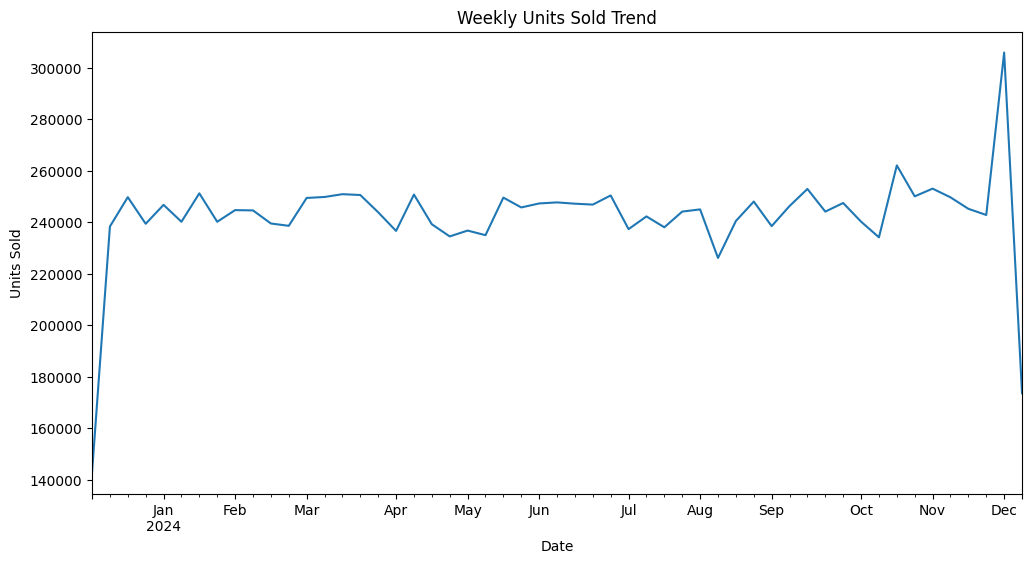

In [316]:
# Units Sold over time
weekly_units = df.groupby(pd.Grouper(key='Transaction_Date', freq='W-SUN'))['Units_Sold'].sum()
weekly_units.plot(title='Weekly Units Sold Trend', figsize=(12,6))
plt.ylabel('Units Sold')
plt.xlabel('Date')
plt.show()

The highest no of units sold is also in November which does make sense

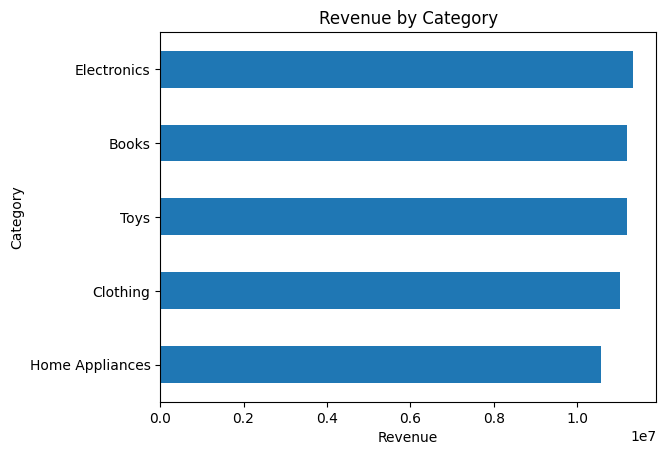

In [317]:
# Revenue by Category
category_revenue = df.groupby('Category')['Revenue'].sum().sort_values()
category_revenue.plot(kind='barh', title='Revenue by Category')
plt.xlabel('Revenue')
plt.show()

Almost the same revenue across the categories (Electronics is higher a little bit)

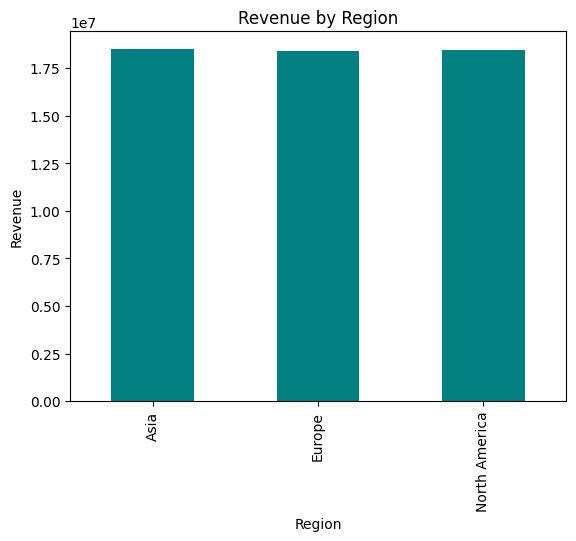

In [318]:
# Revenue by Region
region_rev = df.groupby('Region')['Revenue'].sum()
region_rev.plot(kind='bar', title='Revenue by Region', color='teal')
plt.ylabel('Revenue')
plt.show()

The revenue is the same across the regions

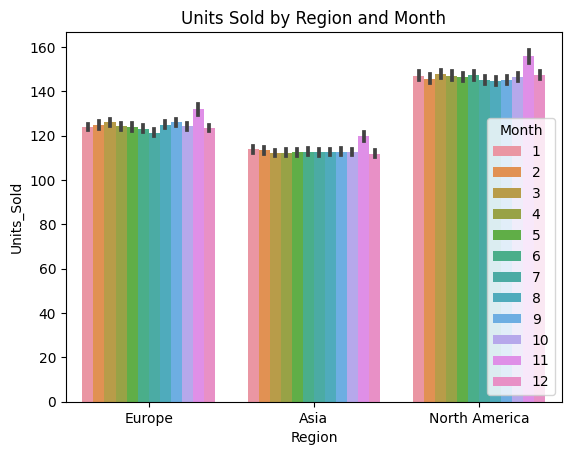

In [319]:
# Units Sold by Region and Season (example seasonal grouping)
df['Month'] = df['Transaction_Date'].dt.month
sns.barplot(data=df, x='Region', y='Units_Sold', hue='Month')
plt.title('Units Sold by Region and Month')
plt.show()

The highest no of units sold is at North America in October

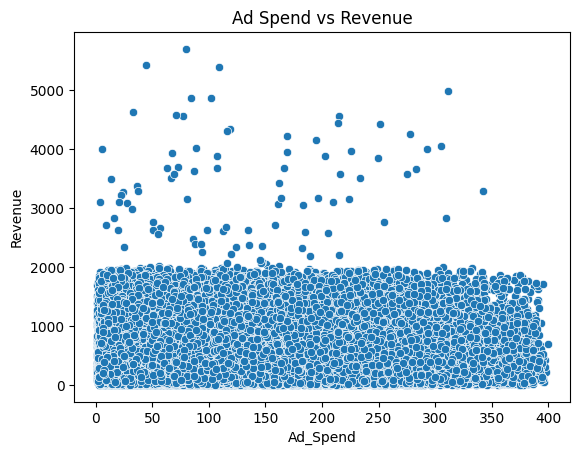

In [320]:
# Ad Spend vs Revenue
sns.scatterplot(data=df, x='Ad_Spend', y='Revenue')
plt.title('Ad Spend vs Revenue')
plt.show()

This shows the advertising effect on the revenue

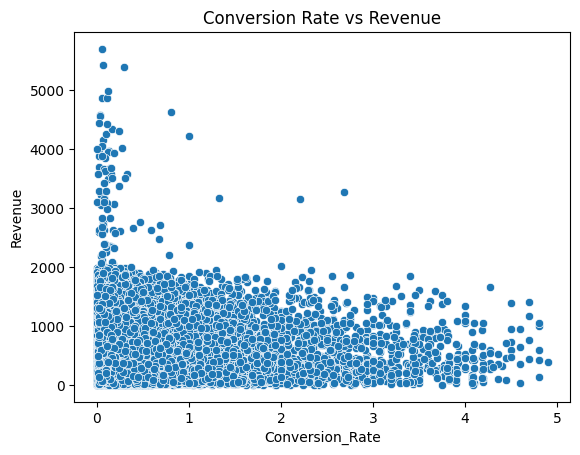

In [321]:
# Conversion Rate vs Revenue
sns.scatterplot(data=df, x='Conversion_Rate', y='Revenue')
plt.title('Conversion Rate vs Revenue')
plt.show()

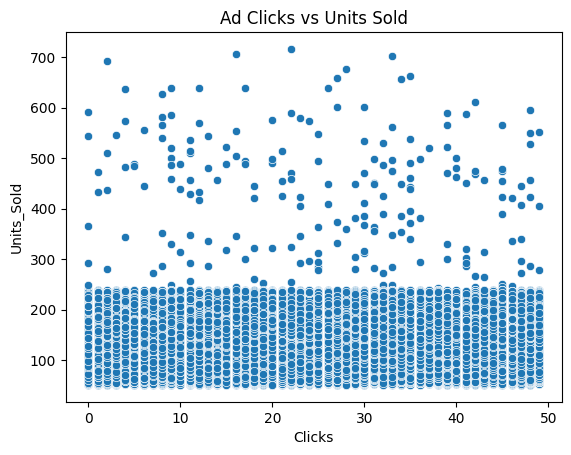

In [322]:
# Clicks vs Units Sold
sns.scatterplot(data=df, x='Clicks', y='Units_Sold')
plt.title('Ad Clicks vs Units Sold')
plt.show()

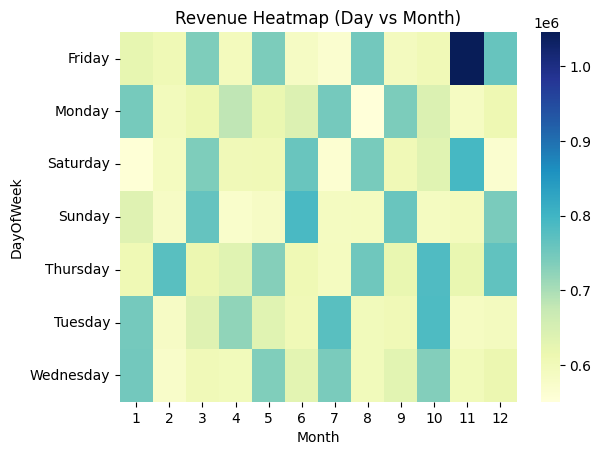

In [323]:
# Heatmap of Revenue by Day of Week and Month
df['DayOfWeek'] = df['Transaction_Date'].dt.day_name()
heatmap_data = df.pivot_table(index='DayOfWeek', columns='Month', values='Revenue', aggfunc='sum')
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Revenue Heatmap (Day vs Month)')
plt.show()

October and November has highest correlations as demonstrated from the other analysis in addition to having the hghest correlation on Friday (which does make sense)

Feature Engineering

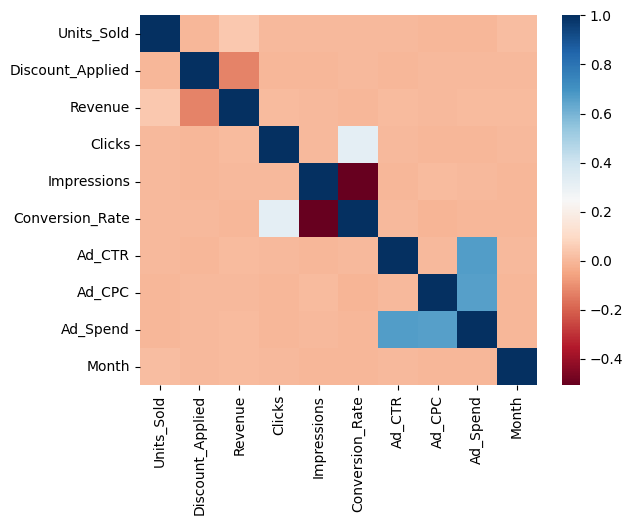

In [324]:
# Heatmap
numerical_cols = df.select_dtypes(include=['number']).columns
sns.heatmap(df[numerical_cols].corr(), cmap="RdBu")
plt.show()

Check what is not too correlated with the target col (units_sold) and leave it while checking the most correlated features (>0.8) to remove them

In [325]:
columns = df.select_dtypes(include=np.number)
correlation_matrix = columns.corr()
# Identify columns to drop
to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        # Check correlation threshold
        if correlation_matrix.iloc[i, j] > 0.8:
            col_to_drop = correlation_matrix.columns[j]
            to_drop.add(col_to_drop)

# Drop the highly correlated columns
df.drop(columns=to_drop, inplace=True)
print("Dropped columns:", to_drop)

Dropped columns: set()


Rounding the float cols to avoid noise effects

In [326]:
float_cols = df.select_dtypes(include=['float64']).columns
df[float_cols] = df[float_cols].round(2)

Processing Categorical Cols

One hot encoding: https://www.geeksforgeeks.org/ml-one-hot-encoding/

In [327]:
# Use pd.get_dummies() to one-hot encode the categorical columns
categorical_columns = ['Category', 'Region']
df_pandas_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

one_hot_encoded = encoder.fit_transform(df[categorical_columns])

# Get feature names and make them unique by prefixing with category
feature_names = encoder.get_feature_names_out(categorical_columns)

one_hot_df = pd.DataFrame(one_hot_encoded,
                            columns=feature_names)

# Reset index of both DataFrames before concatenating
df = pd.concat([df.drop(categorical_columns, axis=1).reset_index(drop=True),
                                one_hot_df.reset_index(drop=True)], axis=1)

Outliers Handling

https://byjus.com/maths/interquartile-range/

In [328]:
numeric_cols = df.select_dtypes(include=['number']).columns
for column in numeric_cols:

    # Calculate the first quartile (Q1) and third quartile (Q3)
    q1, q3 = np.percentile(df[column], [25, 75])

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Set the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Replace outliers with the median value (Q2)
    df[column] = np.where((df[column] < lower_bound) | (df[column] > upper_bound), np.median(df[column]), df[column])

Scaling Based on the cols distribution

In [329]:
# Define column groups
log_cols = ['Ad_Spend', 'Revenue', 'Conversion_Rate']
minmax_cols = ['Ad_CPC', 'Ad_CTR', 'Clicks', 'Impressions', 'Discount_Applied']

# Make a copy of the original DataFrame
df_transformed = df.copy()

# Apply log1p transformation to log-distributed columns
df_transformed[log_cols] = df_transformed[log_cols].apply(np.log1p)

# Apply Min-Max scaling to uniform columns
scaler = MinMaxScaler()
df_transformed[minmax_cols] = scaler.fit_transform(df_transformed[minmax_cols])

In [330]:
# Export to csv
df_transformed.to_csv('../Data/PreparedSalesData.csv', index = False)

<h1>Milestone 3<h1>

Load your cleaned and preprocessed data

In [331]:
# Ensure chronological order and set date as index
df = pd.read_csv('../Data/PreparedSalesData.csv')
df = df.sort_values('Transaction_Date')
df.set_index('Transaction_Date', inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,Units_Sold,Discount_Applied,Revenue,Clicks,Impressions,Conversion_Rate,Ad_CTR,Ad_CPC,Ad_Spend,Month,DayOfWeek,Category_Books,Category_Clothing,Category_Electronics,Category_Home Appliances,Category_Toys,Region_Asia,Region_Europe,Region_North America
Transaction_Date,,,,,,,,,,,,,,,,,,,
2023-12-07,123.0,0.666667,3.696103,0.408163,0.930470,0.039221,0.736842,0.273684,4.512507,12.0,Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-12-07,101.0,0.166667,7.242111,0.081633,0.546012,0.009950,0.473684,0.289474,4.144404,12.0,Thursday,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2023-12-07,108.0,0.500000,7.064255,0.346939,0.613497,0.048790,0.736842,0.131579,3.980989,12.0,Thursday,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2023-12-07,70.0,0.733333,6.709451,0.653061,0.259714,0.207014,0.421053,0.973684,5.146447,12.0,Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2023-12-07,134.0,0.566667,6.563207,0.122449,0.478528,0.019803,1.000000,0.157895,4.393461,12.0,Thursday,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Visualize the target variable (Revenue) over time

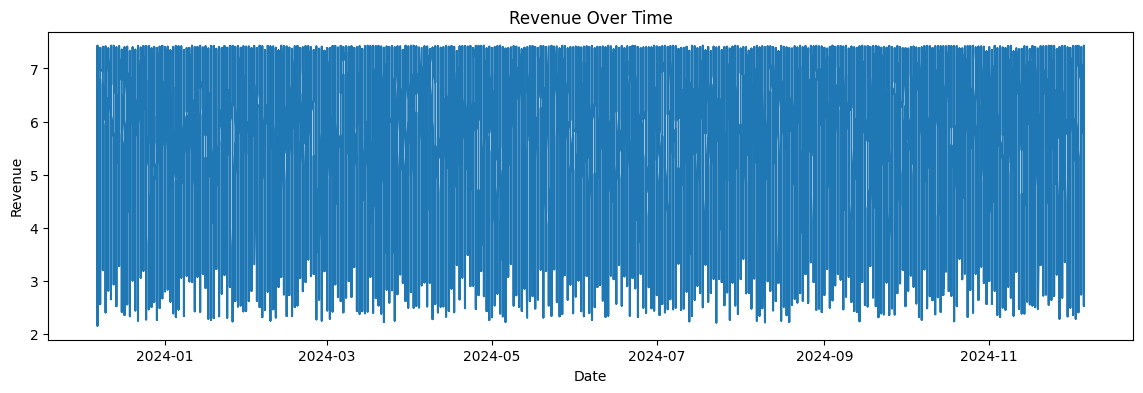

In [332]:
plt.figure(figsize=(14,4))
plt.plot(df['Revenue'])
plt.title('Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

Feature Engineering: create lag and rolling features for ML models

In [333]:
df['month'] = df.index.month
df['dayofweek'] = df.index.dayofweek
df['weekofyear'] = df.index.isocalendar().week.astype(int)
df['quarter'] = df.index.quarter
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# Lag features
for lag in [1, 7, 14, 30]:
    df[f'revenue_lag_{lag}'] = df['Revenue'].shift(lag)
    df[f'units_lag_{lag}'] = df['Units_Sold'].shift(lag)
# Rolling window features
for window in [7, 14, 30]:
    df[f'revenue_rollmean_{window}'] = df['Revenue'].rolling(window).mean()
    df[f'units_rollmean_{window}'] = df['Units_Sold'].rolling(window).mean()

# Example: Holiday flag (Egyptian holidays, can be extended)
holidays = pd.to_datetime([
    '2024-04-10',  # Eid al-Fitr (example)
    '2024-06-16',  # Eid al-Adha (example)
])
df['is_holiday'] = df.index.isin(holidays).astype(int)

# Example: Season
def get_season(month):
    if month in [12, 1, 2]: return 'winter'
    if month in [3, 4, 5]: return 'spring'
    if month in [6, 7, 8]: return 'summer'
    if month in [9, 10, 11]: return 'autumn'
df['season'] = df['month'].apply(get_season)
df = pd.get_dummies(df, columns=['season'], drop_first=True)

# Drop NA from lag/rolling
df = df.dropna()

Train/test split (last 6 months as test set)

In [334]:
split_date = df.index.max() - pd.DateOffset(months=6)
train = df[df.index <= split_date]
test = df[df.index > split_date]

Feature selection

In [335]:
base_features = [
    'Units_Sold', 'Discount_Applied', 'Clicks', 'Impressions', 'Conversion_Rate',
    'Ad_CTR', 'Ad_CPC', 'Ad_Spend', 'month', 'dayofweek', 'weekofyear', 'quarter', 'is_weekend', 'is_holiday',
    'Category_Books', 'Category_Clothing', 'Category_Electronics', 'Category_Home Appliances', 'Category_Toys',
    'Region_Asia', 'Region_Europe', 'Region_North America'
]
lag_roll_features = [col for col in df.columns if 'lag' in col or 'rollmean' in col]
season_features = [col for col in df.columns if col.startswith('season_')]
features = base_features + lag_roll_features + season_features

X_train = train[features]
y_train = train['Revenue']
X_test = test[features]
y_test = test['Revenue']

Model 1 : Random Forest

In [336]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_forecast = rf.predict(X_test)

Model 2 : XGBoost Regressor

In [337]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)

Model 3 : SARIMA (Statistical Time Series Model)

In [338]:
# SARIMA can capture trend and seasonality
sarima_order = (1, 1, 1)  # (p,d,q)
seasonal_order = (1, 1, 1, 12)  # (P,D,Q,s)

sarima_model = SARIMAX(train['Revenue'],
                        order=sarima_order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarima_results = sarima_model.fit(disp=False)

# Forecast for the test period using integer indices
start = len(train)
end = len(train) + len(test) - 1

sarima_pred = sarima_results.get_prediction(start=start, end=end, dynamic=False)
sarima_forecast = sarima_pred.predicted_mean

# Optional: Assign the test dates to the forecast for plotting
sarima_forecast.index = test.index

c:\Users\youse\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\youse\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\youse\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Hyperparameter Tuning for Random Forest

In [339]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None]
}
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                            param_grid,
                            cv=tscv,
                            scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
best_rf_forecast = best_rf.predict(X_test)

Model Evaluation

In [340]:

def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2:   {r2:.2f}")
    print("-" * 30)
    return {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

results.append(evaluate(y_test, rf_forecast, "Random Forest"))
results.append(evaluate(y_test, xgb_forecast, "XGBoost"))
results.append(evaluate(y_test, best_rf_forecast, "Best Random Forest"))
results.append(evaluate(y_test, sarima_forecast, "SARIMA"))


Random Forest Performance:
  MAE:  0.70
  RMSE: 0.88
  R2:   0.15
------------------------------
XGBoost Performance:
  MAE:  0.69
  RMSE: 0.87
  R2:   0.16
------------------------------
Best Random Forest Performance:
  MAE:  0.69
  RMSE: 0.87
  R2:   0.17
------------------------------
SARIMA Performance:
  MAE:  0.75
  RMSE: 0.95
  R2:   -0.00
------------------------------


Error analysis by category and region

In [341]:
for group in ['Category_Books', 'Category_Clothing', 'Category_Electronics', 'Category_Home Appliances', 'Category_Toys']:
    mask = test[group] == 1
    if mask.sum() > 0:
        print(f"Error for {group}:")
        evaluate(y_test[mask], best_rf_forecast[mask], f"Best RF ({group})")

for region in ['Region_Asia', 'Region_Europe', 'Region_North America']:
    mask = test[region] == 1
    if mask.sum() > 0:
        print(f"Error for {region}:")
        evaluate(y_test[mask], best_rf_forecast[mask], f"Best RF ({region})")

Error for Region_Asia:
Best RF (Region_Asia) Performance:
  MAE:  0.68
  RMSE: 0.87
  R2:   0.17
------------------------------
Error for Region_Europe:
Best RF (Region_Europe) Performance:
  MAE:  0.69
  RMSE: 0.87
  R2:   0.17
------------------------------
Error for Region_North America:
Best RF (Region_North America) Performance:
  MAE:  0.69
  RMSE: 0.87
  R2:   0.17
------------------------------


Residual Analysis (for best model)

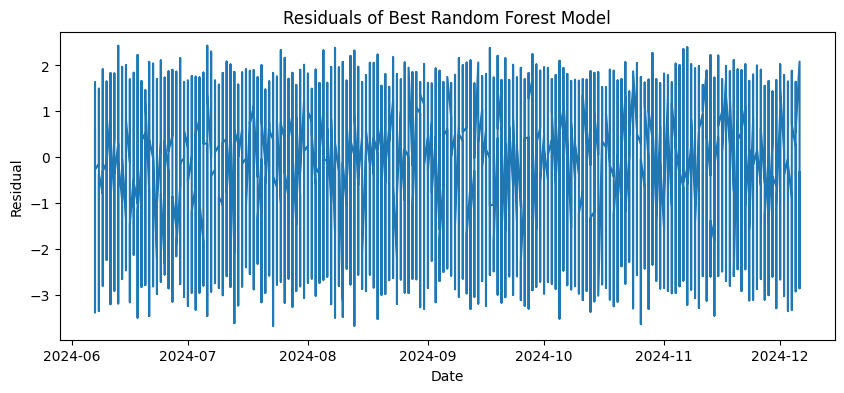

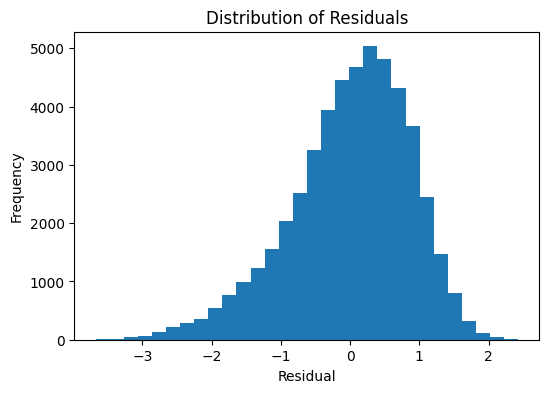

In [342]:
residuals = y_test - best_rf_forecast
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals of Best Random Forest Model')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

Forecast Visualization

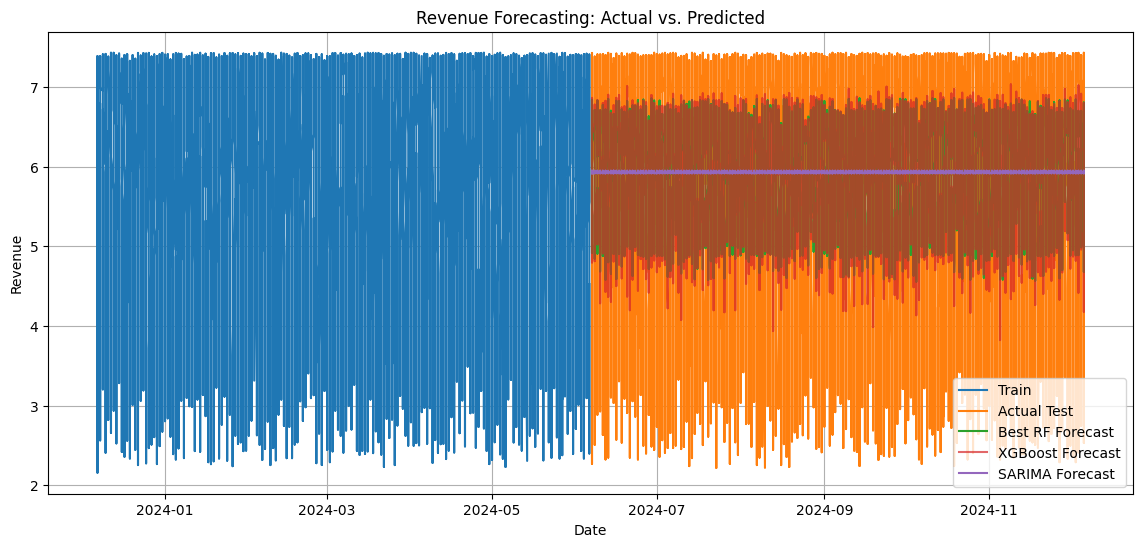

In [343]:
plt.figure(figsize=(14,6))
plt.plot(train.index, train['Revenue'], label='Train')
plt.plot(test.index, y_test, label='Actual Test')
plt.plot(test.index, best_rf_forecast, label='Best RF Forecast')
plt.plot(test.index, xgb_forecast, label='XGBoost Forecast', alpha=0.7)
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.title('Revenue Forecasting: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

Model Comparison Table

In [344]:
results_df = pd.DataFrame(results)
display(results_df)

,model,MAE,RMSE,R2
0,Random Forest,0.698946,0.880932,0.146458
1,XGBoost,0.688975,0.871962,0.163752
2,Best Random Forest,0.688416,0.870861,0.165862
3,SARIMA,0.752795,0.953575,-0.000115


Save the final model for deployment

In [ ]:

joblib.dump(best_rf, 'best_random_forest_revenue_model.pkl')
joblib.dump(xgb_model, 'xgboost_revenue_model.pkl') 

['sarima_revenue_model.pkl']